## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/65

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2024-2025] AN2DL/65


## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load and Process Data

In [ ]:
import numpy as np

data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"X_train shape before healing: {X_train.shape}")

#Foumd by comparing masks and then manually combing all the images
to_remove = [62, 79, 125, 139, 142, 147, 152, 156,
 170, 210, 217, 266, 289, 299, 313, 339,
 348, 365, 412, 417, 426, 450, 461, 536,
 552, 669, 675, 741, 744, 747, 799, 802,
 808, 820, 821, 849, 863, 890, 909, 942,
 971, 1005, 1057, 1079, 1082, 1092, 1095,
 1106, 1119, 1125, 1177, 1194, 1224, 1247,
 1248, 1258, 1261, 1262, 1306, 1324, 1365,
 1370, 1443, 1449, 1508, 1509, 1519, 1551,
 1584, 1588, 1628, 1637, 1693, 1736, 1767,
 1768, 1782, 1813, 1816, 1834, 1889, 1925,
 1942, 1975, 1979, 2000, 2002, 2086, 2096,
 2110, 2111, 2151, 2161, 2222, 2235, 2239,
 2242, 2301, 2307, 2350, 2361, 2365, 2372,
 2414, 2453, 2522, 2535, 2561, 2609, 2614]

for i in reversed(to_remove):
  X_train = np.delete(X_train, i, axis=0)
  y_train = np.delete(y_train, i, axis=0)


print(f"X_train shape after healing: {X_train.shape}")

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=seed
)

# Print information about the data
print(f"\nNumber of clean images:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

X_train shape before healing: (2615, 64, 128)
X_train shape after healing: (2505, 64, 128)

Number of clean images:
Train: 2004
Validation: 501
Test: 10022


In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 25

# Set maximum number of training epochs
EPOCHS = 1000

In [ ]:
# Define category mapping for Mars data
category_map = {
    0: 0,  # Background
    1: 1,  # Soil
    2: 2,  # Bedrock
    3: 3,  # Sand
    4: 4,  # Big Rock
}

# Calculate the number of classes
NUM_CLASSES = len(set(category_map.values()))
print(f"Number of original categories: {len(category_map)}")
print(f"Number of classes after mapping: {NUM_CLASSES}")

Number of original categories: 5
Number of classes after mapping: 5


In [ ]:
flat_labels = np.concatenate([label.flatten().astype(int) for label in y_train])
class_counts = np.bincount(flat_labels, minlength=NUM_CLASSES)

# Calculate class weights
class_weights = 1.0 / np.maximum(class_counts, 1)  # Avoid division by zero
class_weights = 100 * class_weights / class_weights.sum()  # Normalize to sum to 1
cw_dict = {num: class_weights[num] for num in range(0,len(class_weights))}
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)
print("Class Weights Dict:", cw_dict)

Class Counts: [3979893 5532162 3924593 2958791   21329]
Class Weights: [ 0.52445537  0.37729847  0.53184527  0.70544903 97.86095186]
Class Weights Dict: {0: 0.5244553665756885, 1: 0.37729846708158876, 2: 0.5318452747194464, 3: 0.7054490304475768, 4: 97.86095186117569}


In [ ]:
def add_gaussian_noise(image, mean=0, sigma=0.05):

    noise = tf.random.normal(tf.shape(image), mean=mean, stddev=sigma, dtype=tf.float32)

    # Add the noise to the original image
    noisy_image = tf.cast(image, tf.float32) + noise

    # Clip the pixel values to stay within valid range [0, 1]
    noisy_image = tf.clip_by_value(noisy_image, 0, 1)

    # Convert back to uint8 type
    noisy_image = tf.cast(noisy_image, tf.float32)

    return noisy_image

In [ ]:
def color_jitter_np_grayscale(image, brightness=0, contrast=0):

    image = tf.cast(image, tf.float32)

    # Apply brightness adjustment
    if brightness != 0:
        brightness_factor = random.uniform(1 - brightness, 1 + brightness)
        image = image * brightness_factor

    # Apply contrast adjustment
    if contrast != 0:
        mean = tf.reduce_mean(image)
        contrast_factor = random.uniform(1 - contrast, 1 + contrast)
        image = (image - mean) * contrast_factor + mean

    image = tf.clip_by_value(image, 0, 1)
    image = tf.cast(image, tf.float32)

    return image

In [ ]:
def load_single_image(image, label, input_size=(64, 128)):
    """
    Load a single grayscale image-label pair with the correct shape from NumPy arrays.
    Handles cases where the label is None (e.g., during inference).
    """
    # Preprocess the image
    image = tf.image.resize(image[..., None], input_size, method='bilinear')
    image = tf.cast(image, tf.float32) / 255.0

    # Preprocess the label or create a dummy if it's None
    if label is not None:
        label = tf.image.resize(label[..., None], input_size, method='nearest')
        label = tf.cast(label[..., 0], tf.int32)
    else:
        # Create a dummy label with the correct shape and dtype
        label = tf.zeros(input_size, dtype=tf.int32)
    image = color_jitter_np_grayscale(image, brightness=0.6, contrast=0.6)
    image = add_gaussian_noise(image,0,0.025)
    return image, label

In [ ]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [ ]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    seed_ud = None
    if seed is None:
        seed = np.random.randint(0, 1000000)
        seed_ud = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    flip_ud_prob = tf.random.uniform([], seed=seed_ud)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    # Add a channel dimension to the label before flipping
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label[..., None])[..., 0], # Add and remove channel dim
        lambda: label
    )
    image = tf.cond(
        flip_ud_prob > 0.5,
        lambda: tf.image.flip_up_down(image),
        lambda: image
    )
    # Add a channel dimension to the label before flipping
    label = tf.cond(
        flip_ud_prob > 0.5,
        lambda: tf.image.flip_up_down(label[..., None])[..., 0], # Add and remove channel dim
        lambda: label
    )
    return image, label


@tf.function
def random_rotate_180(image, label, seed=None):
    """Consistent random 180º rotation."""
    if seed is None:
        seed = np.random.randint(0, 1000000)

    rotate_prob = tf.random.uniform([], seed=seed)

    image = tf.cond(
        rotate_prob > 0.5,
        lambda: tf.image.rot90(image, k=2),  # Rotate 180º (2 times 90º)
        lambda: image
    )
    # Add a channel dimension to the label before rotating
    label = tf.cond(
        rotate_prob > 0.5,
        lambda: tf.image.rot90(label[..., None], k=2)[..., 0],  # Add and remove channel dim
        lambda: label
    )

    return image, label

In [ ]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset from NumPy arrays.
    Handles cases where labels are None (e.g., during inference).
    """
    # Create dataset from NumPy arrays
    # If labels is None, create a dummy dataset with only images
    if labels is None:
        dataset = tf.data.Dataset.from_tensor_slices(images)
        dataset = dataset.map(lambda image: (image, tf.zeros((64, 128), dtype=tf.int32)))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Augmentation (if enabled)
    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.map(
            lambda x, y: random_rotate_180(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    X_test, None,  # Explicitly pass None for labels
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128)
Labels dtype: <dtype: 'int32'>


Visualizing examples from the training set:


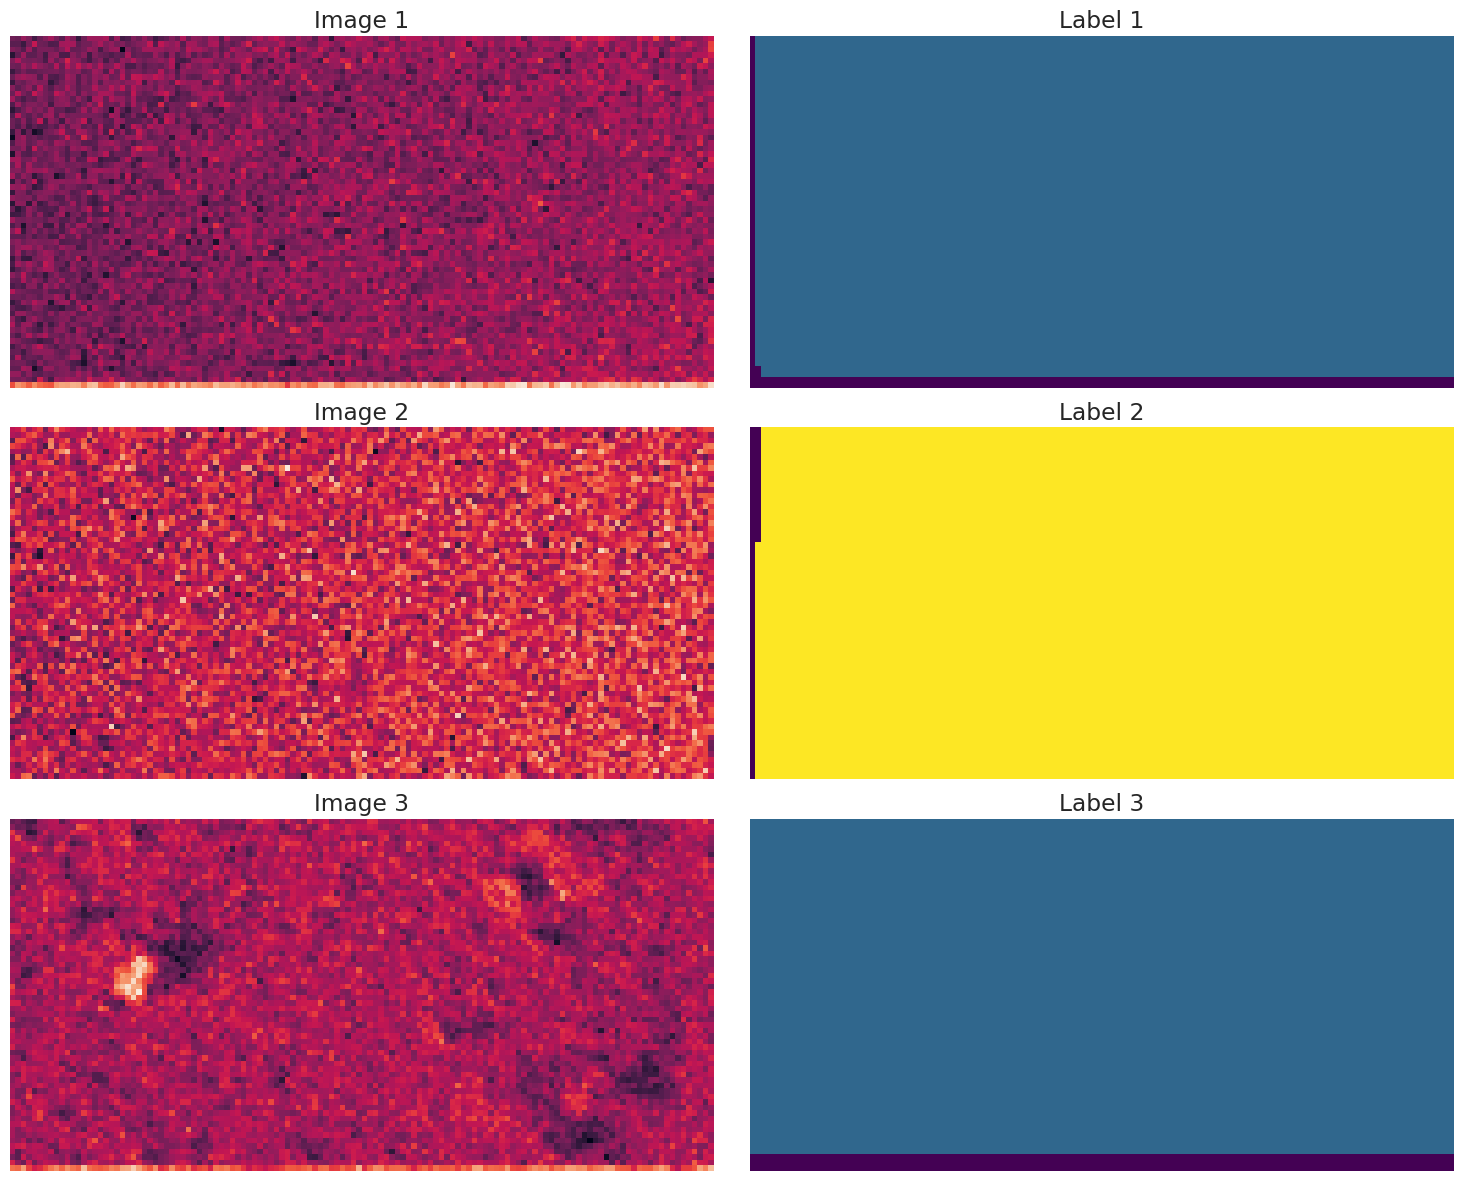

All labels:
0: Background
1: Soil
2: Bedrock
3: Sand
4: Big Rock


In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    for images, labels in dataset.take(1):  # Take one batch
        images_np = images.numpy()  # Convert images to NumPy array
        labels_np = labels.numpy()  # Convert labels to NumPy array

        # Get all possible labels from the class_names dictionary (if available)
        all_labels = list(class_names.keys()) if 'class_names' in globals() else np.unique(labels_np)
        num_classes = len(all_labels)  # Use the total number of classes

        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j * 2 + 1)
            plt.imshow(images_np[j])  # Use images_np here
            plt.title(f'Image {j + 1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j * 2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j + 1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=3)



class_names = {
    0: 'Background',
    1: 'Soil',
    2: 'Bedrock',
    3: 'Sand',
    4: 'Big Rock'
}

#print all the labels
print("All labels:")
for label, name in class_names.items():
    print(f"{label}: {name}")

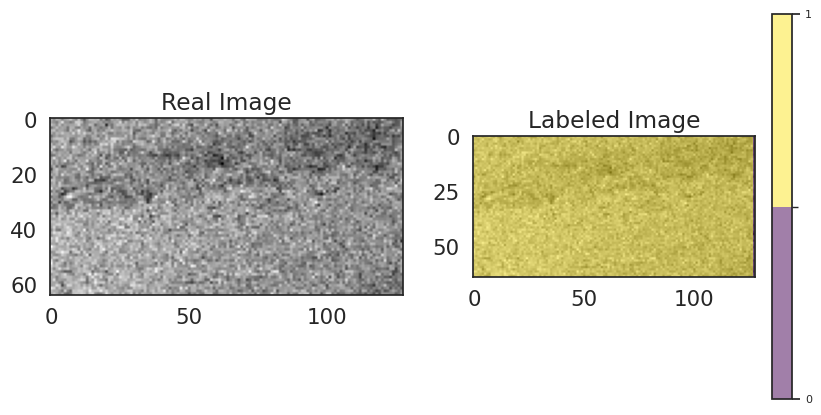

Classes and Labels:
0: Background
1: Soil


In [ ]:
#MORE SPECIFIC PRINTINTG

import matplotlib.colors as mcolors  # Import the necessary module
import matplotlib.pyplot as plt
import numpy as np

for images, labels in train_dataset.take(1):
    first_image = images[0]
    first_label = labels[0]

    # Get unique label values and create a colormap
    unique_labels = np.unique(first_label)
    num_labels = len(unique_labels)
    colors = plt.cm.get_cmap('viridis', num_labels)  # Choose a suitable colormap

    # Create a discrete colormap
    cmap = mcolors.ListedColormap(colors(np.linspace(0, 1, num_labels)))

    # Create a BoundaryNorm to map label values to colors
    bounds = np.arange(num_labels + 1) - 0.5
    # Fix: Use linspace to ensure correct number of ticks for the colorbar
    tick_locations = np.linspace(bounds[0], bounds[-1], num_labels)

    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize as needed

    # Display the real image on the first subplot
    axes[0].imshow(first_image[:, :, 0], cmap='gray')
    axes[0].set_title('Real Image')

    # Overlay the label regions on the second subplot
    axes[1].imshow(first_image[:, :, 0], cmap='gray')  # Show real image as background
    axes[1].imshow(first_label, cmap=cmap, norm=norm, alpha=0.5)
    axes[1].set_title('Labeled Image')

    # Add a colorbar to the second subplot
    cbar = plt.colorbar(
        mappable=axes[1].images[1],  # Associate colorbar with the labeled image
        ax=axes[1],  # Place colorbar on the second subplot
        ticks=tick_locations
    )
    cbar.set_ticklabels(unique_labels)
    cbar.ax.tick_params(labelsize=8)

    plt.show()

    # Print the classes and their labels
    print("Classes and Labels:")
    for label in unique_labels:
        print(f"{label}: {class_names.get(label, 'Unknown')}")


## 🛠️ Models and Experiments

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
def atrous_spatial_pyramid_pooling(x, filters):
    """ASPP block as in DeepLabV3+."""
    pool_size = [1, 2, 3, 6]
    pooling_outputs = []

    for size in pool_size:
        pooling = tfkl.Conv2D(filters, (3, 3), dilation_rate=(size, size), padding='same')(x)
        pooling = tfkl.BatchNormalization()(pooling)
        pooling = tfkl.ReLU()(pooling)
        pooling_outputs.append(pooling)

    # Global Average Pooling
    global_pool = tfkl.GlobalAveragePooling2D()(x)
    global_pool = tfkl.Reshape((1, 1, global_pool.shape[-1]))(global_pool)
    global_pool = tfkl.Conv2D(filters, (1, 1), padding='same')(global_pool)
    global_pool = tfkl.BatchNormalization()(global_pool)
    global_pool = tfkl.ReLU()(global_pool)
    global_pool = tfkl.UpSampling2D(size=(x.shape[1], x.shape[2]))(global_pool) # Add upsampling
    pooling_outputs.append(global_pool)

    # Concatenate all the pooling layers
    x = tfkl.Concatenate()(pooling_outputs)
    return x

In [ ]:
def complex_bottleneck(input_tensor, filters, kernel_size=3, activation='relu', name='bottleneck_'):
    # Residual path
    x = tfkl.Conv2D(filters, kernel_size, padding='same', name=name + 'conv1')(input_tensor)
    x = tfkl.BatchNormalization(name=name + 'bn1')(x)
    x = tfkl.Activation(activation, name=name + 'activation1')(x)

    x = tfkl.Conv2D(filters, kernel_size, padding='same', name=name + 'conv2')(x)
    x = tfkl.BatchNormalization(name=name + 'bn2')(x)

    # Skip connection
    skip = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + 'skip')(input_tensor)
    x = tfkl.Add(name=name + 'add')([x, skip])
    x = tfkl.Activation(activation, name=name + 'activation2')(x)

    # Squeeze-and-Excitation block
    se = atrous_spatial_pyramid_pooling(x,filters)
    se = tfkl.GlobalAveragePooling2D(name=name + 'se_gap')(se)
    se = tfkl.Dense(filters // 4, activation='relu', name=name + 'se_fc1')(se)
    se = tfkl.Dense(filters, activation='sigmoid', name=name + 'se_fc2')(se)
    se = tfkl.Reshape((1, 1, filters), name=name + 'se_reshape')(se)
    x = tfkl.Multiply(name=name + 'se_multiply')([x, se])

    return x


In [ ]:
def adaptive_fusion(features, filters, name="adaptive_fusion"):
    """
    Adaptive Fusion Mechanism to dynamically combine multiple feature maps.
    Args:
        features: List of feature maps to be fused.
        filters: Number of filters for the intermediate processing.
        name: Name prefix for the layers.
    Returns:
        Tensor with adaptively fused features.
    """
    # Concatenate all features
    concat_features = tfkl.Concatenate(name=name + '_concat')(features)

    # Generate attention weights
    attention = tfkl.GlobalAveragePooling2D(name=name + '_gap')(concat_features)
    attention = tfkl.Dense(filters // 4, activation='relu', name=name + '_fc1')(attention)
    attention = tfkl.Dense(len(features), activation='softmax', name=name + '_fc2')(attention)
    attention = tfkl.Reshape((1, 1, len(features)), name=name + '_reshape')(attention)

    # Apply weights to each feature map
    weighted_features = []
    for i, feature in enumerate(features):
        weight = tfkl.Lambda(lambda x: x[:, :, :, i:i+1])(attention)  # Select the i-th weight
        weighted_feature = tfkl.Multiply(name=name + f'_weighted_{i}')([feature, weight])
        weighted_features.append(weighted_feature)

    # Fuse features
    fused_features = tfkl.Add(name=name + '_add')(weighted_features)
    fused_features = tfkl.Conv2D(filters, (1, 1), padding='same', activation='relu', name=name + '_conv')(fused_features)
    return fused_features


In [ ]:
def get_unet_model_with_adaptive_fusion(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)
    ASPP = atrous_spatial_pyramid_pooling(d2, 64)

    # Bottleneck
    bottleneck = complex_bottleneck(ASPP, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Conv2D(64, (1, 1), activation='relu', padding='same')(u1)
    u1 = adaptive_fusion([u1, down_block_2], filters=64, name='fusion1')
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Conv2D(32, (1, 1), activation='relu', padding='same')(u2)
    u2 = adaptive_fusion([u2, down_block_1], filters=32, name='fusion2')
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='unet_model_with_fusion')
    return model




In [ ]:
# Creazione e compilazione del modello
model = get_unet_model_with_adaptive_fusion()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
#tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

Model: "unet_model_with_fusion"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d[0][0] │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 1,522,993 (5.81 MB)

 Trainable params: 1,519,793 (5.80 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [ ]:
"""
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):  # Using tf.keras.metrics.MeanIoU
    def __init__(self, num_classes, name='mean_iou', dtype=None, labels_to_exclude=[0]):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Reshape y_true to match y_pred if needed
        y_true = tf.cast(y_true, tf.int64) #Ensure type consistency
        if y_true.shape != y_pred.shape:
            y_true = tf.reshape(y_true, y_pred.shape) #Reshape only if needed to match

        # Filter out excluded labels
        mask = tf.reduce_all(tf.not_equal(y_true[..., None], self.labels_to_exclude), axis=-1)
        y_true = tf.boolean_mask(y_true, mask)
        y_pred = tf.boolean_mask(y_pred, mask)

        return super().update_state(y_true, y_pred, sample_weight)


    def get_config(self):
        config = super(MeanIntersectionOverUnion, self).get_config()
        config.update({'num_classes': self.num_classes,
                       'labels_to_exclude': self.labels_to_exclude})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
"""


class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):  # Using tf.keras.metrics.MeanIoU
    def __init__(self, num_classes, name='mean_iou', dtype=None, labels_to_exclude=[0], **kwargs): # Added **kwargs
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype, **kwargs) # Pass **kwargs to super()
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Reshape y_true to match y_pred if needed
        y_true = tf.cast(y_true, tf.int64) #Ensure type consistency
        if y_true.shape != y_pred.shape:
            y_true = tf.reshape(y_true, y_pred.shape) #Reshape only if needed to match

        # Filter out excluded labels
        mask = tf.reduce_all(tf.not_equal(y_true[..., None], self.labels_to_exclude), axis=-1)
        y_true = tf.boolean_mask(y_true, mask)
        y_pred = tf.boolean_mask(y_pred, mask)

        return super().update_state(y_true, y_pred, sample_weight)


    def get_config(self):
        config = super(MeanIntersectionOverUnion, self).get_config()
        config.update({'num_classes': self.num_classes,
                       'labels_to_exclude': self.labels_to_exclude})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, frequency=5, colormap=None):
        super().__init__()
        self.dataset = dataset
        self.frequency = frequency
        self.colormap = colormap

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.frequency == 0:
            for images, labels in self.dataset.take(1):
                # Get predictions
                predictions = self.model.predict(images)
                predictions = tf.math.argmax(predictions, axis=-1)  # Get class labels

                # Visualize a few samples
                num_samples_to_visualize = 3
                for i in range(min(num_samples_to_visualize, images.shape[0])):
                    image = images[i].numpy()
                    label = labels[i].numpy()
                    prediction = predictions[i].numpy()

                    # Apply colormap if provided
                    if self.colormap is not None:
                        label = apply_colormap(label, self.colormap)
                        prediction = apply_colormap(prediction, self.colormap)

                    plt.figure(figsize=(10, 3))

                    plt.subplot(1, 3, 1)
                    plt.imshow(image.squeeze(), cmap='gray')  # Adjust cmap if needed
                    plt.title("Image")
                    plt.axis('off')

                    plt.subplot(1, 3, 2)
                    plt.imshow(label)
                    plt.title("True Label")
                    plt.axis('off')

                    plt.subplot(1, 3, 3)
                    plt.imshow(prediction)
                    plt.title("Prediction")
                    plt.axis('off')

                    plt.tight_layout()
                    plt.show()

In [ ]:
import tensorflow as tf

def weighted_categorical_crossentropy(weights):
    """
    Custom loss function for weighted categorical cross-entropy in multiclass segmentation.
    Arguments:
        weights: Tensor of shape (num_classes,) containing class weights.
    Returns:
        Loss function to be used in model compilation.
    """
    def loss(y_true, y_pred):
        # Convert y_true to integer type if it's not already
        if len(y_true.shape) == 3:  # y_true is 2D (height, width), we need to make it 3D (height, width, num_classes)
            y_true = tf.cast(y_true, tf.int32)  # Cast to int32 for one-hot encoding
            y_true = tf.one_hot(y_true, depth=y_pred.shape[-1])  # One-hot encode y_true

        # Clip predictions to avoid log(0) errors
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        # Calculate the cross-entropy for each class (using the softmax probabilities)
        cross_entropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)

        # Reshape weights to (1, 1, 1, num_classes) to match the shape of y_pred
        weights_expanded = tf.reshape(weights, (1, 1, 1, -1))  # Shape: (1, 1, 1, num_classes)

        # Apply class weights to the cross-entropy loss (shape: batch_size, height, width)
        weighted_cross_entropy = cross_entropy * tf.reduce_sum(weights_expanded * y_true, axis=-1)  # Apply weights

        # Return the mean loss over the batch
        return tf.reduce_mean(weighted_cross_entropy)

    return loss


In [ ]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=weighted_categorical_crossentropy(tf.constant([0.01, 0.2, 0.5, 1.2, 3.2])),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")
# weights = [0.1 2.0 3.0 4.0 5.0] => 53.7% on Kaggle
# weights = [0.01 0.06 0.17 0.27 0.49] => 52.8% on Kaggle
# weights = [0.01, 0.2, 0.5, 1.2, 3.2] => 63.3% on Kaggle

Compiling model...
Model compiled!


In [ ]:
PATIENCE = 30

In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

In [ ]:
X_train = X_train.reshape((*X_train.shape, 1))  # Add channel dimension
X_val = X_val.reshape((*X_val.shape, 1))    # Add channel dimension

# Recreate the datasets with the reshaped data:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE) # Add batching
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE) # Add batching


viz_callback = VizCallback(dataset=val_dataset, frequency=5)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    #class_weight=cw_dict,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

In [ ]:
from keras import config

# Abilitare la deserializzazione non sicura
config.enable_unsafe_deserialization()

# Caricare il modello
model = tf.keras.models.load_model(
    model_filename,
    custom_objects={
        'MeanIntersectionOverUnion': MeanIntersectionOverUnion,
        'loss': weighted_categorical_crossentropy
    }
)
print(f"Model loaded from {model_filename}")


Model loaded from UNet_67.13.keras


In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Eugenio Lomurno 📧 eugenio.lomurno@polimi.it





```
   Copyright 2024 Eugenio Lomurno

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```